In [1]:
import numpy as np
import pandas as pd
from pathlib import Path, PurePath
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colormaps as cm

from import_data import *
from model import *
from plotting import *

In [2]:
directory = Path('/home/rombach/code/PL-fitting/project_data')    # where input and data files are saved

database_path = directory / 'input_all.txt'                     # path to input file
input_df = pd.read_csv(database_path, sep='\t')

noise_threshhold = 2
data = import_all_data(directory, input_df, trpl_laser_reference_file, noise_threshhold, plqe_laser_reference_file)

[1.         0.9991364  0.99827356 0.99741147 0.99655015]
[1.         0.87591241 0.95985401 0.91970803 0.89781022]


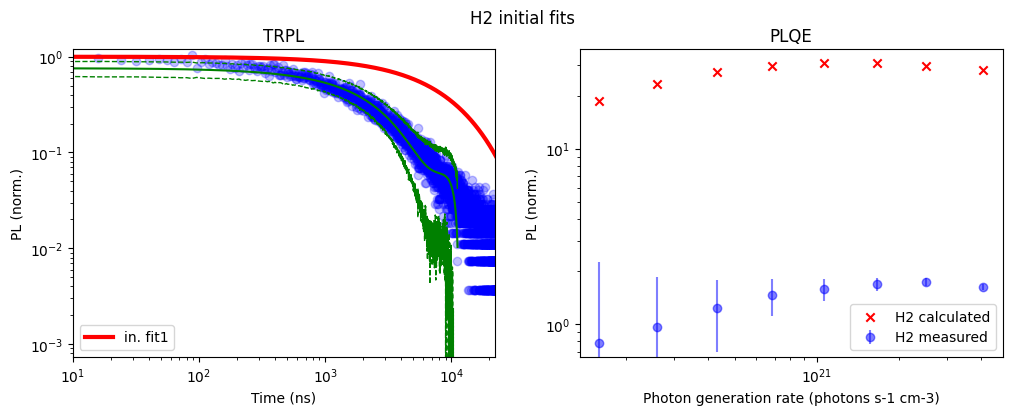

[1.         0.9991364  0.99827356 0.99741147 0.99655015]
[1.         1.00735294 1.05147059 0.95588235 1.01470588]


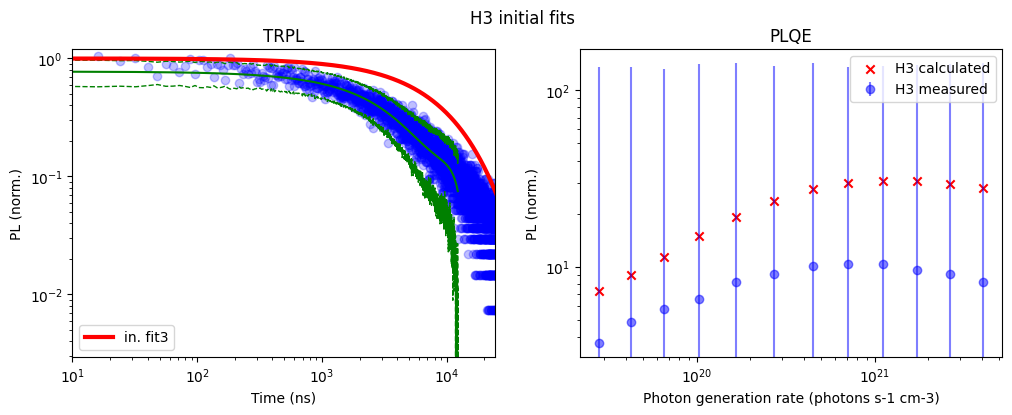

In [3]:
# SET PARAMETERS

# define parameters for each sample [initial value, lower bound, upper bound, distribution type, vary or keep constant]

samples = list(dict.fromkeys(input_df['sample']))
param_dict = defaultdict(dict)

for i in range(len(samples)):

    Eg = list(input_df.loc[input_df['sample']==samples[i], 'bandgap (eV)'])[0]

    #                                             PARAM NAME (for postproc)       INITIAL LBOUND  UBOUND      DISTRIBUTION VARY?
    param_dict[samples[i]]['p_Ef'] = (            [f'E fermi {samples[i]}',       0.2,    0.025,  Eg-0.025,   'normal',     'vary indv'])       # Fermi level of perovskite

    param_dict[samples[i]]['p_Ca'] = (            [f'kaug {samples[i]}',          -27.5,    -28.5,  -26.5,      'normal',   'vary indv'])  # EXP! cm6 s-1 (auger coefficient for nnp)

    param_dict[samples[i]]['p_krad'] = (          [f'krad {samples[i]}',          -10,    -11,    -9,         'normal',   'vary indv'])  # EXP! cm3 s-1 (internal radiative recombination coefficient)
    param_dict[samples[i]]['p_Pa'] = (            [f'Pa {samples[i]}',            0,      0,      1,          'normal',     'vary indv'])       # probability of parasitic absorption
    param_dict[samples[i]]['p_Pr'] = (            [f'Pr {samples[i]}',            0.95,   0,      1,          'normal',     'vary indv'])       # probability of reabsorption by perovskite

    param_dict[samples[i]]['p_N_1'] = (           [f'N trap1 {samples[i]}',       14,     12,     18,         'normal',   'vary indv'])      # EXP! cm-3 (trap density)
    param_dict[samples[i]]['p_depth_trap_1'] = (  [f'E trap1 {samples[i]}',       0.625,    0.625,    Eg-0.05,    'normal',   'vary indv'])  # eV (distance of trap from VB)
    param_dict[samples[i]]['p_bp_1'] = (          [f'beta p trap1 {samples[i]}',  -9,     -12,    -6,         'normal',   'vary indv'])  # EXP! (p capture coefficient)
    param_dict[samples[i]]['p_bn_1'] = (          [f'beta n trap1 {samples[i]}',  -9,     -12,    -6,         'normal',     'vary indv'])       # EXP! (n capture coefficient)

    param_dict[samples[i]]['p_N_2'] = (           [f'N trap2 {samples[i]}',       10,     15,     21,         'normal',   'vary indv'])      # EXP! cm-3 (trap density)
    param_dict[samples[i]]['p_depth_trap_2'] = (  [f'E trap2 {samples[i]}',       0.05,   0.05,   0.1,        'normal',     'vary indv'])       # eV (distance of trap from VB)
    param_dict[samples[i]]['p_bn_2'] = (          [f'beta n trap2 {samples[i]}',  -11.2,     -12,    -6,         'normal',   'vary indv'])  # EXP! (n capture coefficient)
    param_dict[samples[i]]['p_bp_2'] = (          [f'beta p trap2 {samples[i]}',  -6,     -12,    -6,         'normal',     'vary indv'])       # EXP! (p capture coefficient)

    param_dict[samples[i]]['p_A_ct'] = (          [f'Act {samples[i]}',           0,      -0.5,      0.5,        'normal',     'vary indv'])       # scaling of delay (allows begin lower than 1)

# Initial guess plot
param_input_in = {}
param_input_in[samples[0]] = {key: entry[1] for key, entry in param_dict[samples[0]].items()}
for i in range(1, len(samples)):
    param_input_in[samples[i]] = {key: entry[1] for key, entry in param_dict[samples[i]].items()}

plot_fit(directory, samples, input_df, data, param_dict, mode = 'single',
         param_input_in = param_input_in,
         samples_reweighted = None, param_vary_keys = None, param_vary_list = None, nfits = None)

p_Ef 0.025
p_Ef 0.05
p_Ef 0.1
p_Ef 0.2
p_Ef 0.3
p_Ef 0.625


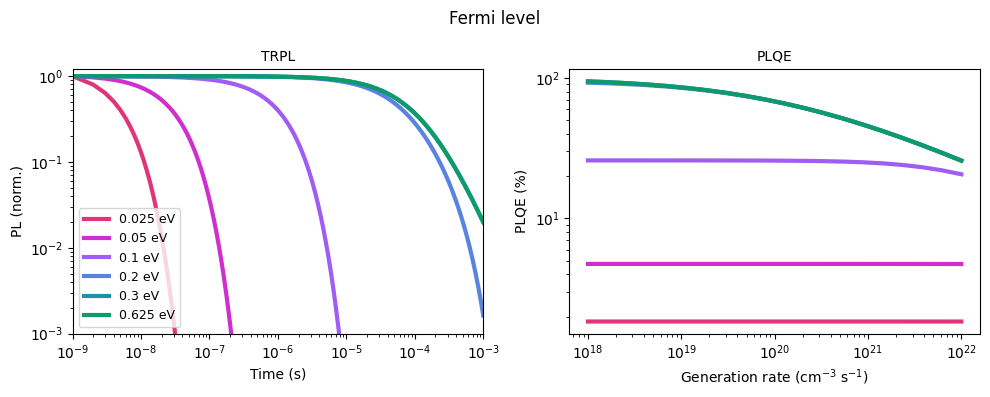

p_Ca -29
p_Ca -28.5
p_Ca -28
p_Ca -27.5
p_Ca -27
p_Ca -26.5


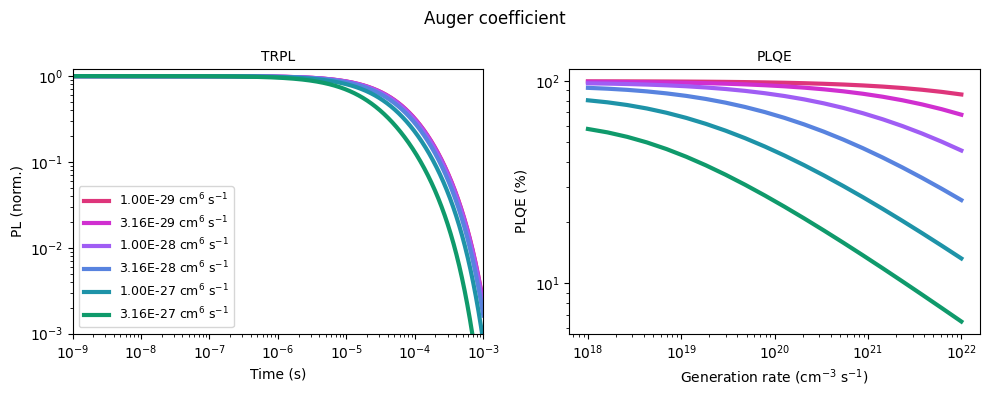

p_krad -11.5
p_krad -11
p_krad -10.5
p_krad -10
p_krad -9.5
p_krad -9


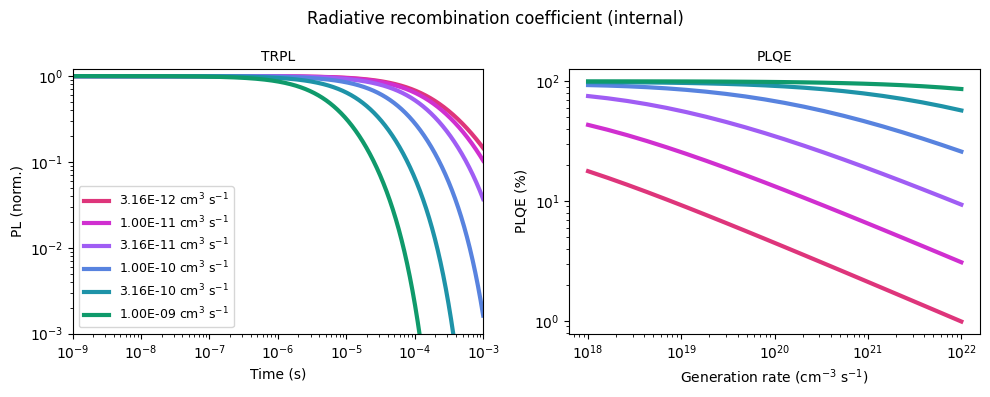

p_N_1 12
p_N_1 13
p_N_1 14
p_N_1 15
p_N_1 16
p_N_1 17


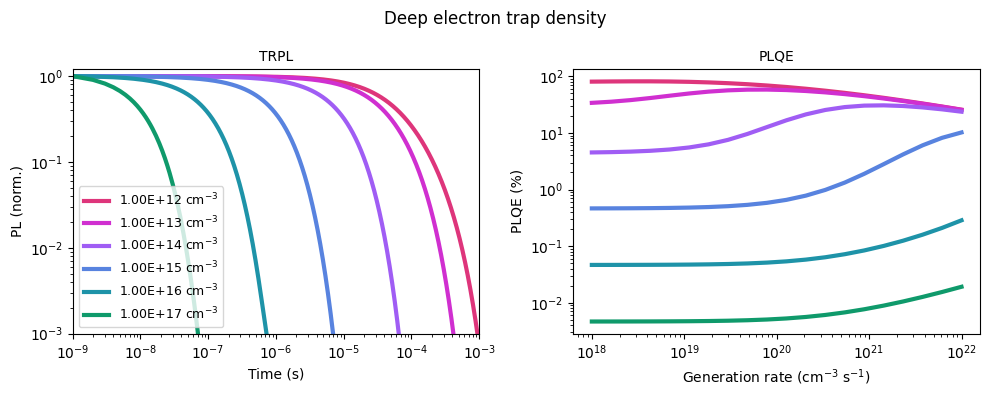

p_N_2 12
p_N_2 13
p_N_2 14
p_N_2 15
p_N_2 16
p_N_2 17


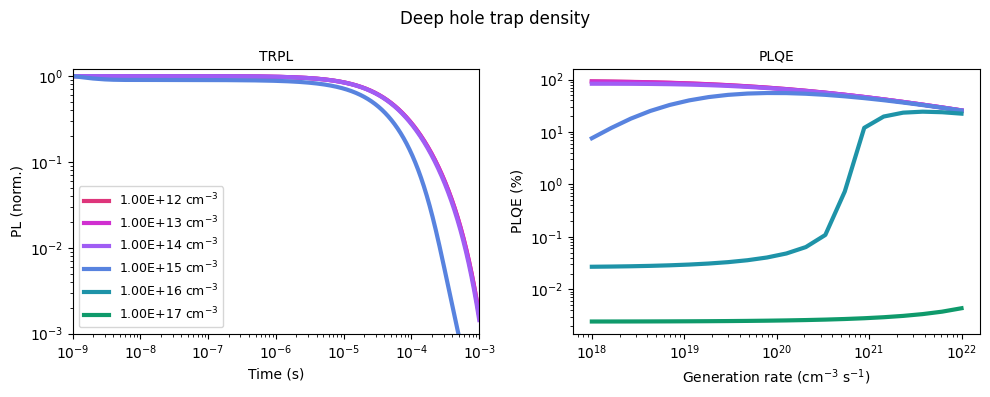

p_bp_1 -12
p_bp_1 -11
p_bp_1 -10
p_bp_1 -9
p_bp_1 -8
p_bp_1 -7
p_bp_1 -6


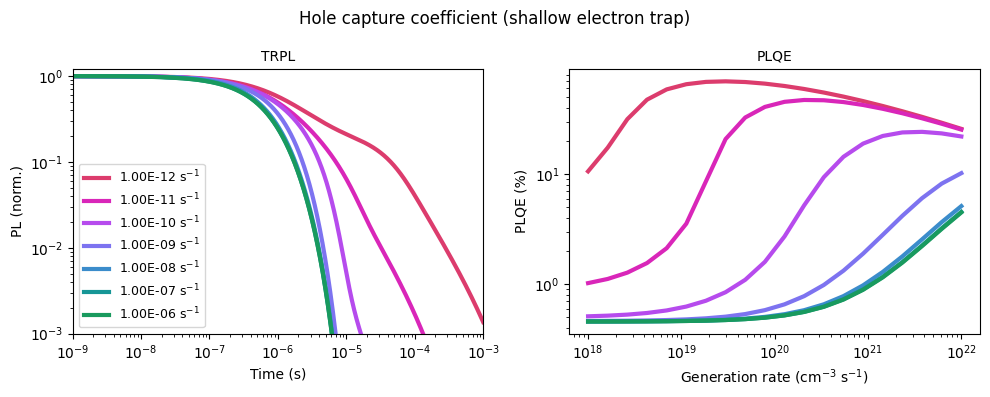

p_bn_2 -12
p_bn_2 -11
p_bn_2 -10
p_bn_2 -9
p_bn_2 -8
p_bn_2 -7
p_bn_2 -6


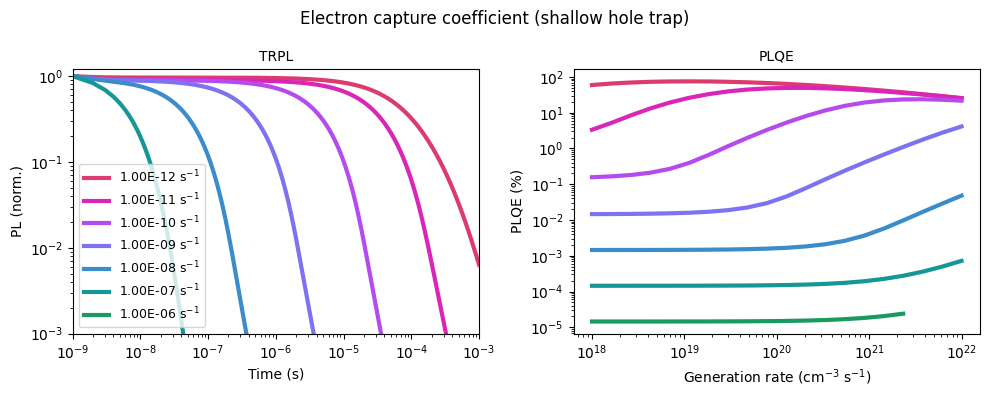

In [7]:
savepath = directory / 'simulations_deeptraps'
savepath.mkdir(exist_ok=True)

param_input = param_input_in

# deep traps

param_input[samples[0]]['p_depth_trap_1'] = 0.9
param_input[samples[0]]['p_depth_trap_2'] = 0.35

sim_list_1 = [('Fermi level', 'p_Ef', [0.025, 0.05, 0.1, 0.2, 0.3, 0.625], [f'{x} eV' for x in [0.025, 0.05, 0.1, 0.2, 0.3, 0.625]]),
            ('Auger coefficient', 'p_Ca', [-29, -28.5, -28, -27.5, -27, -26.5], ["{:.2E}".format(10**x) + ' cm$^6$ s$^{-1}$' for x in [-29, -28.5, -28, -27.5, -27, -26.5]]),
            ('Radiative recombination coefficient (internal)', 'p_krad', [-11.5, -11, -10.5, -10, -9.5, -9], ["{:.2E}".format(10**x) + ' cm$^3$ s$^{-1}$' for x in [-11.5, -11, -10.5, -10, -9.5, -9]]),
            ('Deep electron trap density', 'p_N_1', [12, 13, 14, 15, 16, 17], ["{:.2E}".format(10**x) + ' cm$^{-3}$' for x in [12, 13, 14, 15, 16, 17]]), #deep e trap (0.35 eV)
            ('Deep hole trap density', 'p_N_2', [12, 13, 14, 15, 16, 17], ["{:.2E}".format(10**x) + ' cm$^{-3}$' for x in [12, 13, 14, 15, 16, 17]]), #deep e trap (0.05 eV)
            ]

for elem in sim_list_1:

    plot_sim(savepath, samples, input_df, data, param_dict, param_input_in, 
             elem[1], elem[2], elem[0], elem[3])

param_input[samples[0]]['p_N_1'] = 15
plot_sim(savepath, samples, input_df, data, param_dict, param_input_in, 
             'p_bp_1', [-12, -11, -10, -9, -8, -7, -6], 'Hole capture coefficient (shallow electron trap)', ["{:.2E}".format(10**x) + ' s$^{-1}$' for x in [-12, -11, -10, -9, -8, -7, -6]])
param_input[samples[0]]['p_N_1'] = 10

param_input[samples[0]]['p_N_2'] = 15
plot_sim(savepath, samples, input_df, data, param_dict, param_input_in, 
             'p_bn_2', [-12, -11, -10, -9, -8, -7, -6], 'Electron capture coefficient (shallow hole trap)', ["{:.2E}".format(10**x) + ' s$^{-1}$' for x in [-12, -11, -10, -9, -8, -7, -6]])
param_input[samples[0]]['p_N_2'] = 10


p_N_1 14
p_N_1 15
p_N_1 16
p_N_1 17
p_N_1 18
p_N_1 19


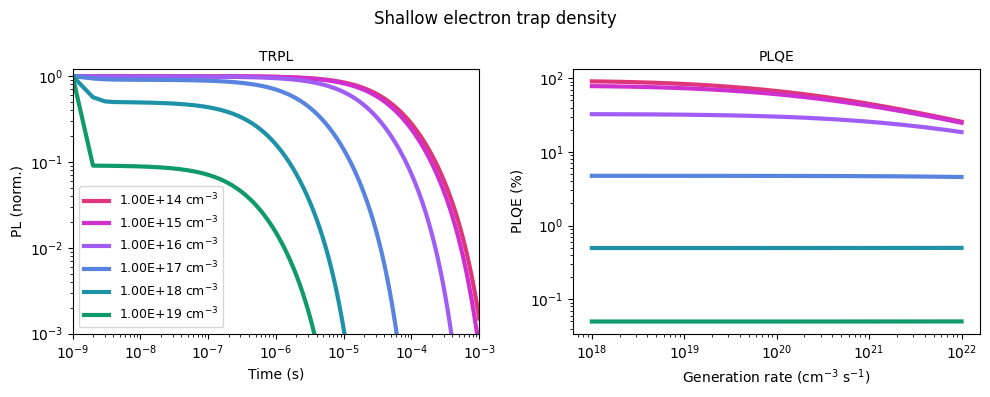

p_N_2 14
p_N_2 15
p_N_2 16
p_N_2 17
p_N_2 18
p_N_2 19


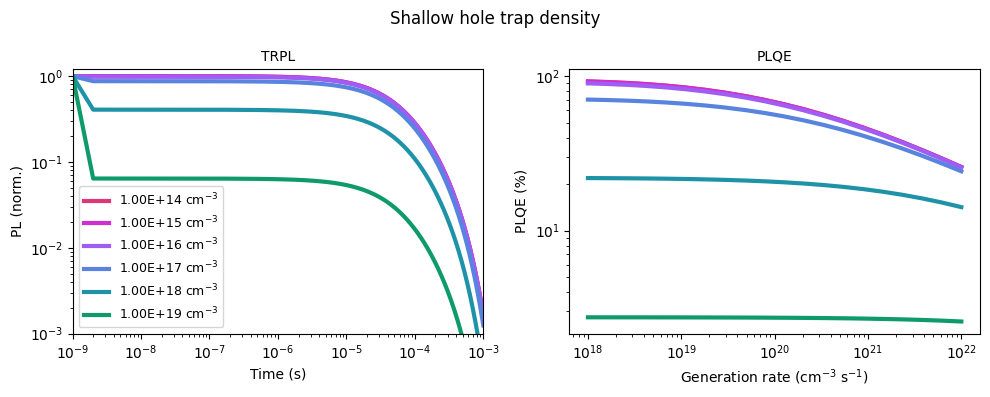

p_bp_1 -12
p_bp_1 -11
p_bp_1 -10
p_bp_1 -9
p_bp_1 -8
p_bp_1 -7
p_bp_1 -6


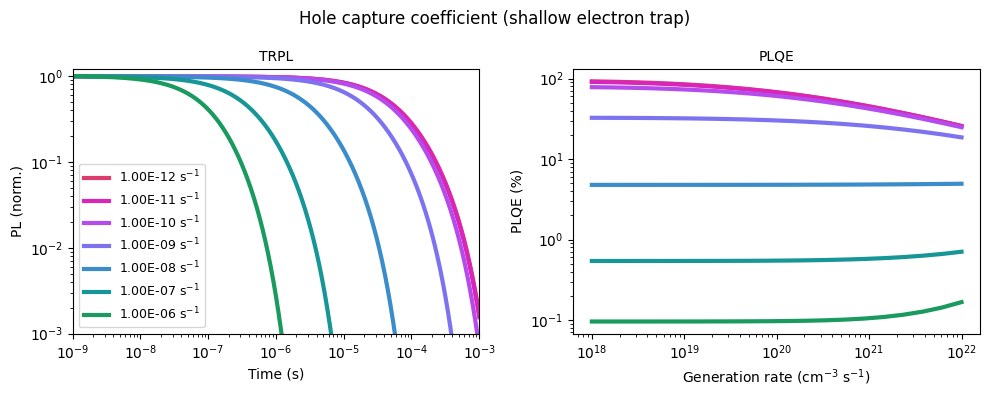

p_bn_2 -12
p_bn_2 -11
p_bn_2 -10
p_bn_2 -9
p_bn_2 -8
p_bn_2 -7
p_bn_2 -6


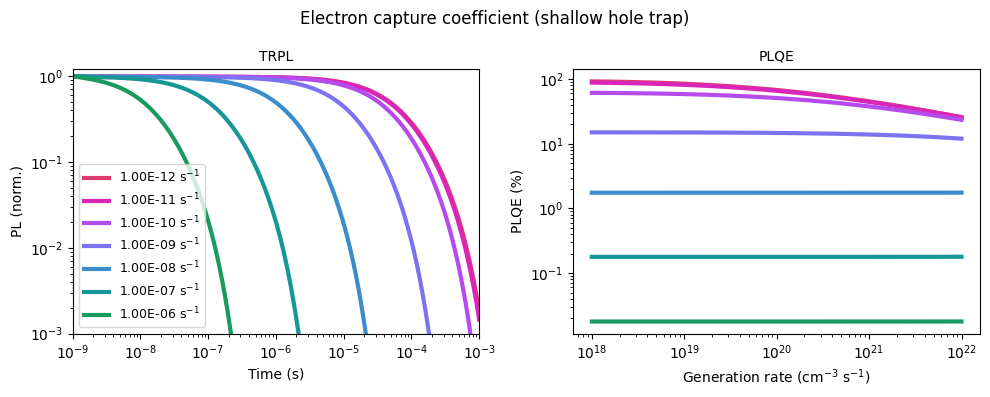

In [6]:
savepath = directory / 'simulations_shallowtraps'
savepath.mkdir(exist_ok=True)

# shallow traps

param_input[samples[0]]['p_depth_trap_1'] = 1.20
param_input[samples[0]]['p_depth_trap_2'] = 0.05

sim_list_1 = [('Shallow electron trap density', 'p_N_1', [14, 15, 16, 17, 18, 19], ["{:.2E}".format(10**x) + ' cm$^{-3}$' for x in [14, 15, 16, 17, 18, 19]]), #deep e trap (0.35 eV)
            ('Shallow hole trap density', 'p_N_2', [14, 15, 16, 17, 18, 19], ["{:.2E}".format(10**x) + ' cm$^{-3}$' for x in [14, 15, 16, 17, 18, 19]]), #deep e trap (0.05 eV)
            ]

for elem in sim_list_1:

    plot_sim(savepath, samples, input_df, data, param_dict, param_input_in, 
             elem[1], elem[2], elem[0], elem[3])

param_input[samples[0]]['p_N_1'] = 16
plot_sim(savepath, samples, input_df, data, param_dict, param_input_in, 
             'p_bp_1', [-12, -11, -10, -9, -8, -7, -6], 'Hole capture coefficient (shallow electron trap)', ["{:.2E}".format(10**x) + ' s$^{-1}$' for x in [-12, -11, -10, -9, -8, -7, -6]])
param_input[samples[0]]['p_N_1'] = 10

param_input[samples[0]]['p_N_2'] = 16
plot_sim(savepath, samples, input_df, data, param_dict, param_input_in, 
             'p_bn_2', [-12, -11, -10, -9, -8, -7, -6], 'Electron capture coefficient (shallow hole trap)', ["{:.2E}".format(10**x) + ' s$^{-1}$' for x in [-12, -11, -10, -9, -8, -7, -6]])
param_input[samples[0]]['p_N_2'] = 10

# trap depth

